# 📡 Sarcasm detector

Dataset original source:

- [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Build a predictive model

- Compare: NB, KNN, SVM

Theorical sources

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)
- [ROC curve](https://stackabuse.com/understanding-roc-curves-with-python/)

Sklearn references

- [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [Hyper parameter tunning](https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6)

## 🏷 Table of content
* [Libraries](#libraries)
* [The data](#the-data)
* [Exploratory data analysis](#exploratory-data-analysis)
* [How to vectorize text](#how-to-vectorize-text)
* [End to end modeling](#end-to-end-modeling)
* [Conclusions](#conclusions)

## 📝 Libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import scipy
from time import time
import os

import nltk 
# IMPORNTANT: install this the first time
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

import dill as picker

if os.path.exists('notebook_env.db'):
    print('There is a notebook session saved in the environment')

import warnings
warnings.filterwarnings('ignore')

There is a notebook session saved in the environment


## 🔡 The data <a class="anchor" id="the-data"></a>

In [2]:
dataset_name = 'Sarcasm_Headlines_Dataset.json'
X_a = pd.read_json(dataset_name, lines=True)

In [3]:
X_a.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## 🕵 Exploratory data analysis <a class="anchor" id="exploratory-data-analysis"></a>

In [4]:
X_a.shape

(26709, 3)

In [5]:
X_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
X_a.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Get ride of duplicated headlines

In [7]:
X_a['headline'].duplicated().sum()

107

In [8]:
X_a[X_a['headline'].duplicated()].index

Int64Index([ 1091,  2265,  2975,  3802,  4605,  5154,  5789,  6383,  6642,
             6685,
            ...
            25115, 25118, 25855, 25995, 26026, 26121, 26156, 26353, 26500,
            26615],
           dtype='int64', length=107)

In [9]:
X_a = X_a.drop(X_a[X_a['headline'].duplicated()].index, axis=0)

In [10]:
X_a['headline'].duplicated().sum()

0

In [11]:
X_a.shape

(26602, 3)

### Get ride of duplicate features

#### The transmitter

In [12]:
df = X_a.copy()

In [13]:
extract_transmitter = lambda url : url.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)
df.head()

,article_link,headline,is_sarcastic,transmitter
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


### Distributions

In this section you notice that:

1. The dependent variable is unbalanced
2. Using feature engineering we can find a variable that predicts with 100% of accuracy if it's a sarcastic quote or not

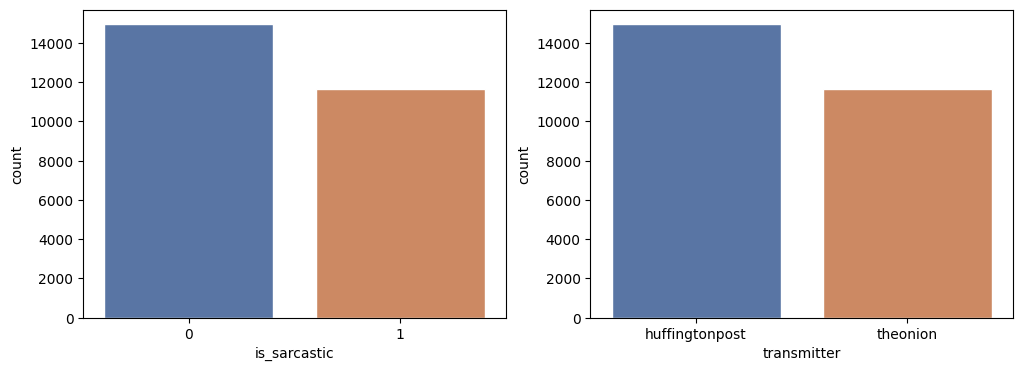

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df, ax = ax1)

sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df, ax = ax2)

In [15]:
df['is_sarcastic'].value_counts()

0    14951
1    11651
Name: is_sarcastic, dtype: int64

In [16]:
df['transmitter'].value_counts()

huffingtonpost    14951
theonion          11651
Name: transmitter, dtype: int64

#### Linear correlation between features

It's important to note that a matrix of all ones is a very unlikely scenario in real-world data, as it would indicate that all of the variables are perfectly related and there is no variability or uniqueness in the data. However, with this information I deduce that **theonion** source always throw sarcastic headlines meanwhile **huffingtonpost** always gives non-sarcastic headlines.

The conclusion here is that if I mantein the **transmitter** feature created from feature engineering I am more like to create an acurate model with the disatventage to need the source emitter.

In [17]:
from pandas import factorize
columns = ['transmitter', 'is_sarcastic']
X = df[columns]
X.loc[:, 'transmitter'] = factorize(X['transmitter'])[0]

In [18]:
# calculate the correlation matrix
corr = X.corr()
corr

,transmitter,is_sarcastic
transmitter,1.0,1.0
is_sarcastic,1.0,1.0


## 🔨 How to vectorize text? <a class="anchor" id="how-to-vectorize-text"></a>

In this section I present the way I map from raw text to vectorized samples in order to inject the vectorized samples into M.L models

### Denoise headlines

In this section I present the way I clean the text and transform to simple phrases using the **nltk** library and removing stop words

In [19]:
def denoise_text(text: str):
    
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    
    def concat(tokens):
        return ' '.join(tokens)

    # lower case
    text = text.lower()
    
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return concat(tokens)

In [20]:
df['clean_headline'] = df['headline'].apply(denoise_text)
df[['headline', 'clean_headline']].head(10)

,headline,clean_headline
0,former versace store clerk sues over secret 'b...,former versac store clerk sue secret black cod...
1,the 'roseanne' revival catches up to our thorn...,roseann reviv catch thorni polit mood better wors
2,mom starting to fear son's web series closest ...,mom start fear son web seri closest thing gran...
3,"boehner just wants wife to listen, not come up...",boehner want wife listen come altern debt redu...
4,j.k. rowling wishes snape happy birthday in th...,j k rowl wish snape happi birthday magic way
5,advancing the world's women,advanc world woman
6,the fascinating case for eating lab-grown meat,fascin case eat lab grown meat
7,"this ceo will send your kids to school, if you...",ceo send kid school work compani
8,top snake handler leaves sinking huckabee camp...,top snake handler leav sink huckabe campaign
9,friday's morning email: inside trump's presser...,friday morn email insid trump presser age


#### Most commond words in headlines

In this section you'll see the most recurrent words used in sarcastic headlines and in not sarcastic headlines. This may gives us an idea of how sarcastic quotes are diferenciated from non sarcastic quotes.

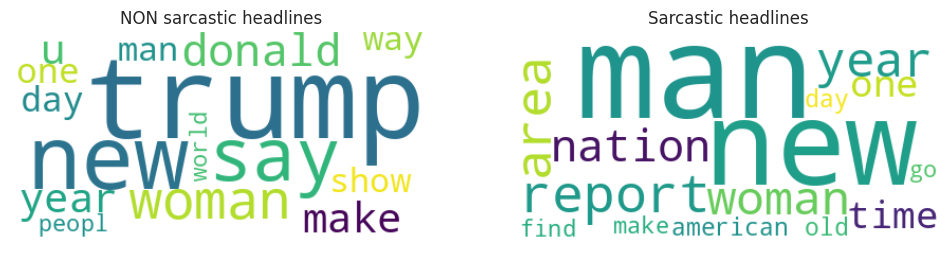

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# more frequent words used in not sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 0]['clean_headline'])
wc = WordCloud(
    max_words = 15, 
    collocations = False, 
    background_color = 'white') \
    .generate(ns_words)
ax1.imshow(wc , interpolation = 'bilinear')
ax1.axis('off')
ax1.set_title('NON sarcastic headlines')


# more frequent words used in sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 1]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
ax2.imshow(wc , interpolation = 'bilinear')
ax2.axis("off")
ax2.set_title('Sarcastic headlines')


plt.show()

### Vectorize words

To add context to the machine learning algorithm, I use ngrams of size 1 and 2. This makes increase the size of data but I hope it helps the algoritms to be more acurate.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['clean_headline']
vectorizer = CountVectorizer(
    dtype='int32', 
    analyzer='word', 
    ngram_range=(1,1),
    min_df=1)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

In [23]:
X.shape

(26602, 16976)

In [24]:
feature_names[100:125]

array(['abduct', 'abdul', 'abe', 'abedin', 'abhorr', 'abid', 'abil',
       'abject', 'abl', 'aboard', 'abolish', 'abomin', 'abort',
       'aboveground', 'abraham', 'abram', 'abramson', 'abridg', 'abroad',
       'abruptli', 'absenc', 'absent', 'absentmind', 'abso', 'absolut'],
      dtype=object)

In [25]:
# X.toarray() <- Even decreasing the number of bits to representing the data, it does not work, I have 8gb of ram and it exceeds 14gb
sdf = pd.DataFrame.sparse.from_spmatrix(X)
sdf[['is_sarcastic', 'transmitter']] = df[['is_sarcastic', 'transmitter']]

In [26]:
sdf[list(range(10)) + ['is_sarcastic', 'transmitter']].head()

,0,1,2,3,4,5,6,7,8,9,is_sarcastic,transmitter
0,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
1,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
2,0,0,0,0,0,0,0,0,0,0,1.0,theonion
3,0,0,0,0,0,0,0,0,0,0,1.0,theonion
4,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost


In [27]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


## 🔮 End to End Modeling<a class="anchor" id="end-to-end-modeling"></a>

As I want this project be portable, I'll use the end-to-end desing pattern. Which, being brief, consist in having the transformations and the modeling in the same workflow, programmatically as I'm using **sklearn**, it means using *Pipelines* and *Transformers*.

In [28]:
picker.load_session('notebook_env.db')

### Transformations

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformers

# cleans noise from raw text
class TextDenoiser(BaseEstimator, TransformerMixin):
    
    def __denoise_text(self, text):
        from nltk.tokenize import RegexpTokenizer
        from nltk.corpus import stopwords
        from nltk.stem import PorterStemmer, WordNetLemmatizer
        
        def concat(tokens):
            return ' '.join(tokens)

        # lower case
        text = text.lower()

        # remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)

        # remove numbers
        tokens = [token for token in tokens if not token.isnumeric()]

        # remove stop words
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]

        # stem words
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return concat(tokens)

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__denoise_text)
        return X

    
# Transform url into transmitter categorical variable 
# (NOT USED ANYMORE as I see this features give me height performance but It makes models dependent from this variable and I dont want it!)
class TransmitterExtracter(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # self.input_features = X.columns
        return self
    
    def __extracter(self, text):
        return text.split('.')[1]

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__extracter)
        return X

In [30]:
text_processor_pipeline = Pipeline(steps=[
            ('denoiser', TextDenoiser()),
            ('ct', ColumnTransformer(transformers=[
                ('v', CountVectorizer(
                        dtype='int32',
                        analyzer='word',
                        min_df=1), 0)
                ])
            )
  ])

# Column transformer get's ride of no transformed columns
preprocessor = ColumnTransformer(
    transformers=[
        #('tf1', transmitter_processor_pipeline, ['article_link']),
        ('tf1', text_processor_pipeline, ['headline']),
    ],
    #remainder='passthrough'
)

In [31]:
X = X_a.drop(['is_sarcastic', 'article_link'], 1)
y = X_a['is_sarcastic']
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_numpy())

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

type(X_train), type(y_train)

(scipy.sparse._csr.csr_matrix, pandas.core.series.Series)

In [33]:
print('Training dataset shape features', X_train.shape)
print('Training dataset shape labels', y_train.shape)
print('Test dataset shape features', X_test.shape)
print('Test dataset shape labels', y_test.shape)

Training dataset shape features (21281, 15421)
Training dataset shape labels (21281,)
Test dataset shape features (5321, 15421)
Test dataset shape labels (5321,)


In [34]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


### Modeling

In [35]:
picker.load_session('notebook_env.db')

In [36]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

I import some metrics to know how good my models behave. As the default distribution of my data is unbalanced I'll use **f1** score as the trusted metric estimator

In [37]:
from sklearn.model_selection import GridSearchCV

Because I rather work with Jupyterlab instead of Google Collab and I need my machine I'll use RandomizedSearchCV instead of GridSearchCV in order to pick random params and accelerate the train process. I also lower the CV validations splits to 3 instead of 5 which is the default.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_numpy())

I use the 20% of the original sample to make the test. The splited samples are not randomly, it uses stratify mechanism as we know that the data is a litte biassed, because we have more samples of non-sarcastic quotes. If I do this, I force that the distribution in the test samples follow this rule

In [39]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, predictions, classes):
    cm = confusion_matrix(y_test, predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    disp.plot()
    plt.show()

AUC–ROC curve is the model selection metric for bi–multi class classification problem. 
ROC is a probability curve for different classes. ROC tells us how good the model is 
for distinguishing the given classes, in terms of the predicted probability.
The area covered by the curve is the area between the orange line (ROC) and the axis. 
This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. 
ideal value for AUC is 1.

In [40]:
def plot_roc_curve(pipe, X_test, y_test):
    from sklearn.metrics import RocCurveDisplay
    _ = RocCurveDisplay.from_estimator(pipe, X_test, y_test)

In [41]:
# Here I save the best models
M = {}

In [42]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


In [43]:
# preprocessor.get_params().keys()

#### Multinomial NB

In [44]:
picker.load_session('notebook_env.db')

In [45]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('mnb', MultinomialNB())
])

alphas = np.concatenate(
    (np.linspace(0.05, 1, 3), np.linspace(2, 4, 3)), 
    axis=None)

ngrams = [(1, 1), (1, 2)]

grid_params = {
  'mnb__alpha': alphas,
  'mnb__fit_prior': [True],  
  'preprocessor__tf1__ct__v__ngram_range': ngrams
}

start=time()

rsp = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 5,
    scoring = 'f1',
    n_jobs=-1
)
rsp.fit(X_train, y_train)

elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  43.32  seconds


In [46]:
print("Best Params: ", rsp.best_params_)

Best Params:  {'mnb__alpha': 0.525, 'mnb__fit_prior': True, 'preprocessor__tf1__ct__v__ngram_range': (1, 2)}


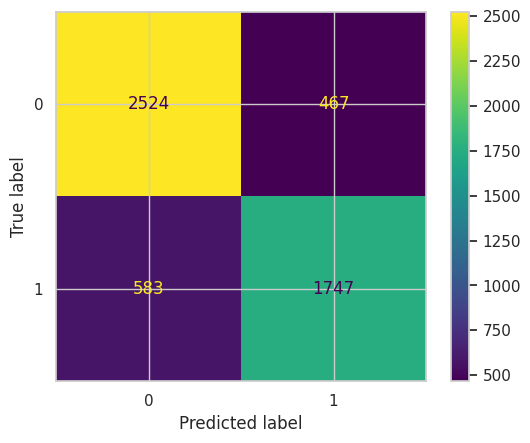

In [47]:
pipe_nb = rsp.best_estimator_
y_pred = pipe_nb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_nb.classes_)

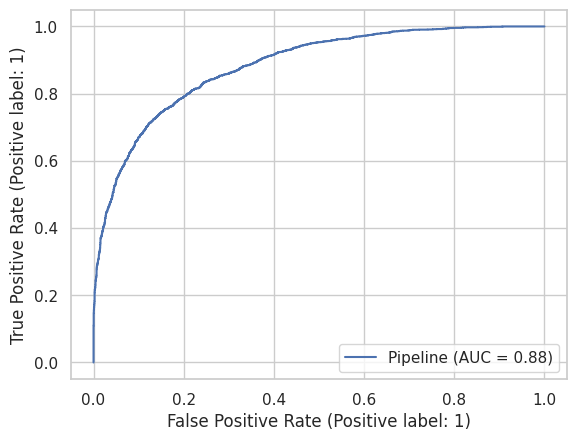

In [48]:
plot_roc_curve(pipe_nb, X_test, y_test)

In [49]:
M['multinomial_nb'] = {
    'model': pipe_nb,
    'time': elapsed
}

In [50]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


### KNN

In [51]:
picker.load_session('notebook_env.db')

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline ([
    ('preprocessor', preprocessor),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier(algorithm='kd_tree', weights='uniform', metric='minkowski'))
])

ngrams = [(1, 1), (1, 2)]

grid_params = {
  'knn__n_neighbors': [15,30,45,60,75,90],
  'preprocessor__tf1__ct__v__ngram_range': ngrams,
  'knn__p': [1, 2],
  'knn__leaf_size': [10, 20]
}

start=time()
rsp = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 5,
    scoring = 'f1',
    n_jobs=-1
)

rsp.fit(X_train, y_train)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  292.18  seconds


/root/repos/sarcasm-detection/env/lib/python3.8/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/root/repos/sarcasm-detection/env/lib/python3.8/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/root/repos/sarcasm-detection/env/lib/python3.8/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/root/repos/sarcasm-detection/env/lib/python3.8/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/root/repos/sarcasm-detection/env/lib/python3.8/site-packages/sklearn/ne

In [98]:
print("Best Params: ", rsp.best_params_)

Best Params:  {'knn__leaf_size': 10, 'knn__n_neighbors': 45, 'knn__p': 2, 'preprocessor__tf1__ct__v__ngram_range': (1, 2)}


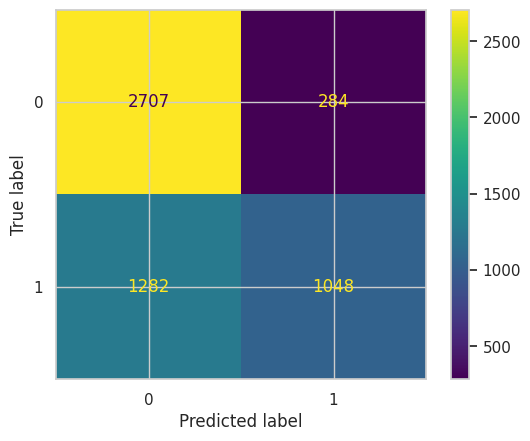

In [99]:
pipe_knn = rsp.best_estimator_
y_pred = pipe_knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_knn.classes_)

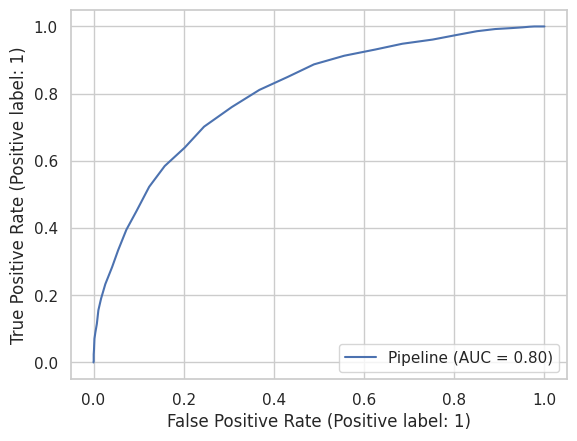

In [100]:
plot_roc_curve(pipe_knn, X_test, y_test)

In [101]:
M['knn'] = {
    'model': pipe_knn,
    'time': elapsed
}

In [57]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


### SVM

In [58]:
picker.load_session('notebook_env.db')

In [59]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

text_processor_pipeline = Pipeline(steps=[
            ('denoiser', TextDenoiser()),
            ('ct', ColumnTransformer(transformers=[
                ('v', CountVectorizer(
                        dtype='int32',
                        analyzer='word',
                        min_df=1), 0)
                ])
            ),
            ('scaler', StandardScaler(with_mean=False))
  ])

# Column transformer get's ride of no transformed columns
preprocessor = ColumnTransformer(
    transformers=[
        #('tf1', transmitter_processor_pipeline, ['article_link']),
        ('tf1', text_processor_pipeline, ['headline']),
    ],
    #remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

ngrams = [(1, 1), (1, 2)]

grid_params = {
    'svc__C': [0.1, 0.9, 9],
    'svc__kernel': ['linear', 'rbf'],
    'svc__cache_size': [ 200, 400 ],
    'preprocessor__tf1__ct__v__ngram_range': ngrams,
}

start=time()

rsp = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 3,
    scoring = 'f1'
)
rsp.fit(X_train, y_train)

elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  3236.43  seconds


In [60]:
print("Best Params: ", rsp.best_params_)

Best Params:  {'preprocessor__tf1__ct__v__ngram_range': (1, 1), 'svc__C': 9, 'svc__cache_size': 200, 'svc__kernel': 'rbf'}


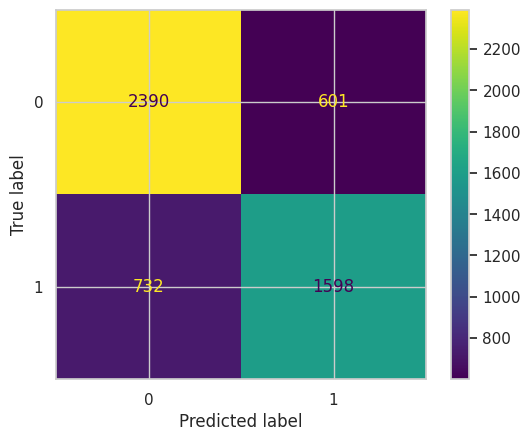

In [61]:
pipe_svc = rsp.best_estimator_
y_pred = pipe_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_svc.classes_)

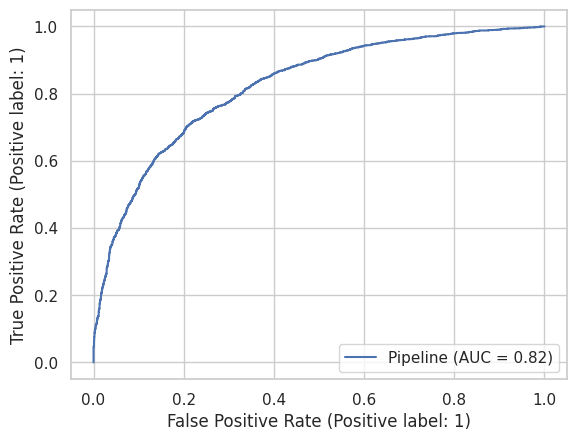

In [62]:
plot_roc_curve(pipe_svc, X_test, y_test)

In [63]:
M['svm'] = {
    'model': pipe_svc,
    'time': elapsed
}

In [64]:
picker.dump_session('notebook_env.db')
print('LAST DUMP')

LAST DUMP


## 🧐 Conclusions <a class="anchor" id="conclusions"></a>

As we can see in the following lines of code and graphics, not only does Multinomial Naive Bayes perform better compared to other models during testing, but also its training time is significantly faster than the others. While the others take almost 5 minuts and an hour for KNN and SVM respectively, Naive Bayes' training time is less than a minute.

SVM has a better perfomarmance compared to KNN but it's trainning time is 10X of KNN. To get out of trouble I would use KNN instead of SVM even thought it's performance is poorer. Clearly, the model to pick in this text model classification is Multinomial Naive Bayes. 

In [65]:
picker.load_session('notebook_env.db')

In [102]:
import os
from sklearn import metrics

does_exist = os.path.exists('./metrics.csv')
recover = False

if does_exist and recover:
    df = pd.read_csv('./metrics.csv')
else:
    precision_score = []
    recall_score = []
    f1_score = []
    accuracy_score = []
    times = []
    models = []
    
    for name, data in M.items():
        model = data['model']
        train_time = data['time']
        y_pred = model.predict(X_test)
        
        models.append(name)
        times.append(train_time)
        precision_score.append(metrics.precision_score(y_test, y_pred, average='weighted'))
        recall_score.append(metrics.recall_score(y_test, y_pred, average='weighted'))
        f1_score.append(metrics.f1_score(y_test, y_pred, average='weighted'))
        accuracy_score.append(metrics.accuracy_score(y_test , y_pred))
    
    columns = {
        'precision_score': precision_score, 
        'recall_score': recall_score, 
        'f1_score': f1_score,
        'accuracy_score' : accuracy_score,
        'train_time': times
    }
    
    df = pd.DataFrame(columns, index = models)
    df.to_csv('metrics.csv', index = True)
    
df = df.sort_values('f1_score', ascending = False)
df

,precision_score,recall_score,f1_score,accuracy_score,train_time
multinomial_nb,0.802161,0.802669,0.802027,0.802669,43.321797
svm,0.748527,0.749483,0.748544,0.749483,3236.434612
knn,0.725983,0.705694,0.686631,0.705694,292.181070


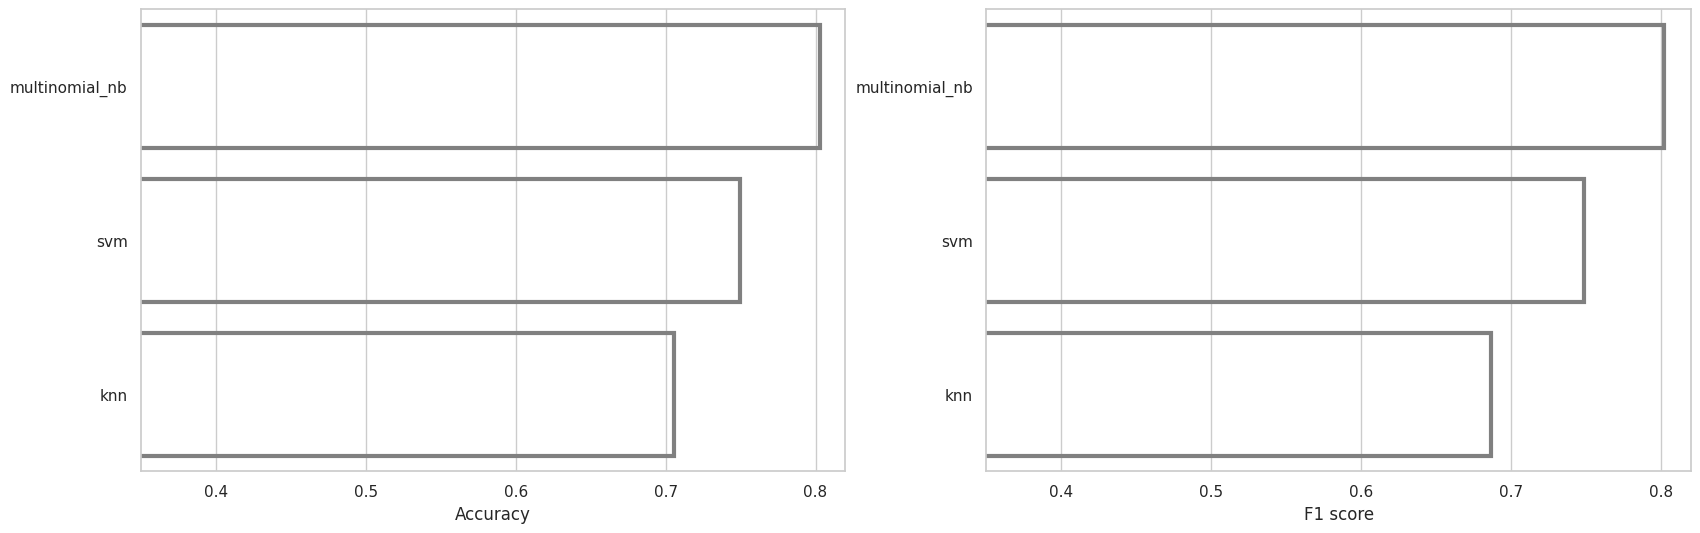

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax = sns.barplot(
            data=df, 
            y=df.index, 
            x=df["accuracy_score"],
            capsize=.4,
            linewidth=3, 
            edgecolor=".5", 
            facecolor=(0, 0, 0, 0),
            ax=ax1)
_ = ax.axes.set_xlim((0.35, 0.82))
_ = ax.axes.set(xlabel ="Accuracy")


ax = sns.barplot(
            data=df, 
            y=df.index, 
            x=df["f1_score"],
            capsize=.4,
            linewidth=3, 
            edgecolor=".5", 
            facecolor=(0, 0, 0, 0),
            ax=ax2)
_ = ax.axes.set_xlim((0.35, 0.82))
_ = ax.axes.set(xlabel ="F1 score")

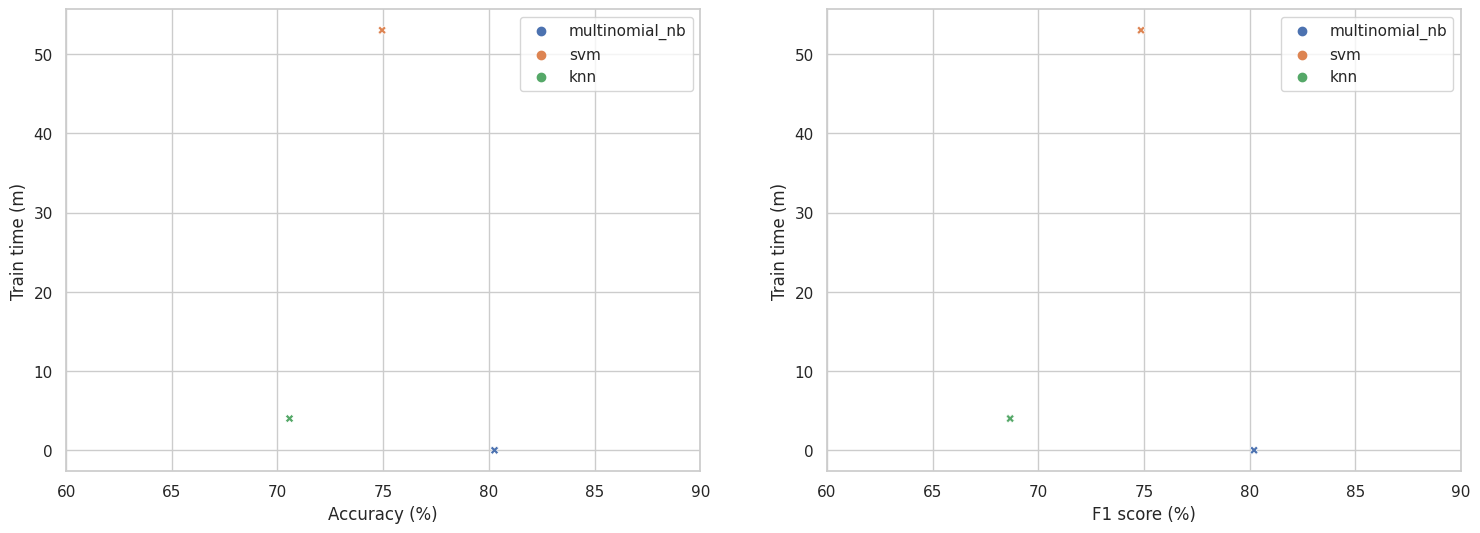

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax = sns.scatterplot(
    data=df, 
    y=df["train_time"] // 60,
    x=df["accuracy_score"] * 100,
    hue=df.index,
    marker="X",
    ax=ax1)
_ = ax.axes.set(ylabel ="Train time (m)", xlabel = "Accuracy (%)")

_ = ax.set_xlim(60, 90)

ax = sns.scatterplot(
    data=df, 
    y=df["train_time"] // 60,
    x=df["f1_score"] * 100,
    hue=df.index,
    marker="X",
    ax=ax2)
_ = ax.axes.set(ylabel ="Train time (m)", xlabel = "F1 score (%)")

_ = ax.set_xlim(60, 90)